In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from kernel import KernelComputer, KernelRegressor
from ranking import BasicFasSolver, IlpSolver, AC, IL, SP
from dataloader import Synthesizer
from ranking.fassolver.embedding import get_sym_embs

In [2]:
%matplotlib inline
np.random.seed(0)

In [3]:
class DF:
    def __init__(self, kernel, fas_solver):
        self.kernel = kernel
        self.solver = fas_solver
        self.is_ilp = type(self.solver) == IlpSolver

    def train(self, x_train, S_train, lambd, threshold=1e-3, nb_epochs=1, solver=None, quadratic=False, method='FW'):
        if solver is None:
            solver = self.solver
        n_train = len(S_train)

        self.kernel.set_support(x_train)
        K = self.kernel.get_k()
        w, v = np.linalg.eigh(K)
        w_reg = w / (w + n_train * lambd)
        alpha = (w_reg * v) @ v.T
        
        if quadratic:
            alpha = alpha.T @ alpha
            y_train = self.quadratic_disambiguation(alpha, S_train, method, nb_epochs, solver)
        else:
            y_train = self.disambiguation(alpha, S_train, threshold, solver)

        self.beta = v / (w + n_train * lambd) @ (v.T @ y_train)
        self.y_train = y_train
        
    def __call__(self, x, verbose=False):
        out = self.kernel(x).T @ self.beta
        out *= -1
        for i in range(len(x)):
            if self.is_ilp:
                self.solver.set_objective(out[i])
                out[i] = self.solver.solve()
            else:
                self.solver.solve_out(out[i], out[i])
            if verbose and not (100 * i) % len(x):
                print(i, end=", ")
        return out
    
    @staticmethod
    def disambiguation(alpha, S_train, threshold, solver):
        is_ilp = type(solver) == IlpSolver
        y_train = S_train.astype(np.float)
        const = S_train.astype(np.float)

        z = np.zeros(y_train.shape)
        z_old = np.ones(y_train.shape)
        while not np.abs(z - z_old).max() > 1e-3:
            z_old[:] = z[:]

            # Minimization over z
            np.matmul(alpha, y_train, out=z)
            z *= -1
            for i in range(len(z)):
                if is_ilp:
                    solver.set_objective(z[i])
                    z[i] = solver.solve()
                else:
                    solver.solve_out(z[i], z[i])

            # Minimization over y
            np.matmul(alpha, z, out=y_train)
            y_train *= -1
            for j in range(len(y_train)):
                if is_ilp:
                    solver.set_constraints(const[j])
                    solver.set_objective(y_train[j])
                    y_train[j] = solver.solve()
                else:
                    solver.solve_const_out(y_train[j], const[j], y_train[j])
    
            if is_ilp:
                solver.reset_constraints()

        return y_train
        
    @staticmethod
    def quadratic_disambiguation(alpha, S_train, method, nb_epochs, solver):
        is_ilp = type(solver) == IlpSolver
        y_train = S_train.astype(np.float)
        const = S_train.astype(np.float)

#         alpha -= np.eye(n_train)
        if method.lower() == 'bw':
            # Blockwise Frank-Wolfe    
            n_train = len(y_train)
            for t in range(nb_epochs):
                i = np.random.randint(n_train)

                if is_ilp:
                    solver.set_constraints(const[i])
                    solver.set_objective(-alpha[i] @ y_train)
                    dir_bw = solver.solve()
                else:
                    dir_bw = solver.solve_const(-alpha[i] @ y_train, const[i])

                y_train[i] *= t / (2*n_train + t)
                y_train[i] += (2*n_train / (2*n_train + t)) * dir_bw
    
        else:
            # Frank-Wolfe
            for t in range(nb_epochs):
                dir_fw = alpha @ y_train
                dir_fw *= -1
                for i in range(len(dir_fw)):
                    if is_ilp:
                        solver.set_constraints(const[i])
                        solver.set_objective(dir_fw[i])
                        dir_fw[j] = solver.solve()
                    else:
                        solver.solve_const_out(dir_fw[i], const[i], dir_fw[i])

                dir_fw -= y_train
                dir_fw *= 2 / (t + 2)
                y_train += dir_fw
    
        if is_ilp:
            solver.reset_constraints()
            
#         y_train = aux_argmax == y_train.argmax(axis=1)[:, np.newaxis]
        return y_train

In [4]:
import numba


@numba.jit("(f8[:, :], f8[:, :], i8[:, :])", nopython=True)
def fill_distance(dist, y_score, ind_map):
    m = len(ind_map)
    for j in range(m):
        for i in range(j):
            ind = ind_map[i, j]
            dist[:,ind] = y_score[i] - y_score[j]

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [5]:
m = 4
n_test = 200

datagen = Synthesizer('RK-' + str(m))
x_test, (y_test, y_score) = datagen.get_testset(n_test, verbose=True)

In [6]:
ind_map = datagen.loader.ind_map

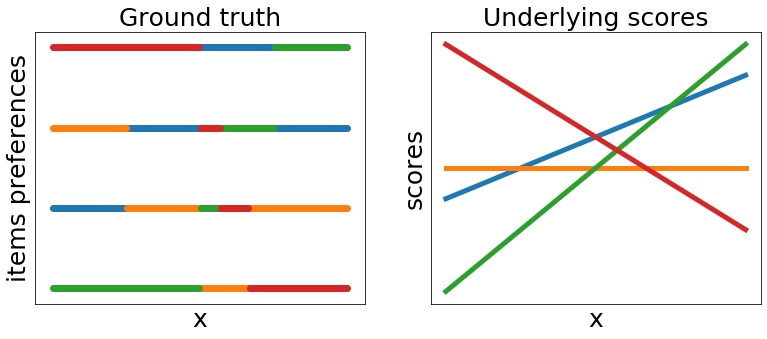

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13,5))
y = get_sym_embs(y_test, ind_map).sum(axis=-1).argsort()
for i in range(y.shape[1]):
    ax1.scatter(x_test, (y == i).argmax(axis=1))
    ax2.plot(x_test, y_score[i], linewidth=5)
ax1.set_title('Ground truth', size=25)
ax1.set_ylabel('items preferences', size=25)
ax2.set_title('Underlying scores', size=25)
ax2.set_ylabel('scores', size=25)
for ax in [ax1, ax2]:
    ax.set_xlabel("x", size=25)
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)
fig.savefig('savings/ranking_setting.pdf')

In [8]:
nb_folds = 8
corruptions = np.linspace(0, 1, num=8)
sigmas = [1e0, 5e-1, 1e-1, 5e-2]
lambdas = [1e3, 1e0, 1e-3, 1e-6]

n_train = 20
n_test = 50

In [9]:
kernel = KernelComputer('Gaussian', sigma=1)
kernel_reg = KernelRegressor(kernel)

In [10]:
m = 10
datagen = Synthesizer('RK-' + str(m))
ind_map = datagen.loader.ind_map

solver = IlpSolver(ind_map)
solver.choose_solver_method('primal')
solver.shut_up()

# solver = BasicFasSolver(ind_map)

msolver = IlpSolver(ind_map)
msolver.choose_solver_method('dual')
# msolver.shut_up()

met_ac = AC(kernel_reg.kernel, solver)
met_il = IL(kernel_reg.kernel, solver)
met_df = DF(kernel_reg.kernel, solver)

In [ ]:
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

err_ac = -np.ones(shape_err)
err_il = -np.ones(shape_err)
err_df = -np.ones(shape_err)

for fold in range(nb_folds):
    datagen = Synthesizer('RK-' + str(m))
    x_train, (y_train, y_score) = datagen.get_trainset(n_train, verbose=True)
    x_test, y_test = datagen.get_trainset(n_test)
    kernel_reg.set_support(x_train[:, np.newaxis])
    n_train, dim = x_train[:, np.newaxis].shape    

    for i_s, c_sigma in enumerate(sigmas):
        sigma = c_sigma * dim
        kernel_reg.update_sigma(sigma)

        for i_l, c_lambda in enumerate(lambdas):
            lambd = c_lambda / np.sqrt(n_train)
            kernel_reg.update_lambda(lambd)
            alpha_train = kernel_reg(x_train[:, np.newaxis])
            alpha_train += alpha_train.T

            for i_c, corruption in enumerate(corruptions):
                S_train = y_train.copy()
                
                dist = np.empty(S_train.shape)
                fill_distance(dist, y_score, datagen.loader.ind_map)
                np.abs(dist, out=dist)
                dist /= np.max(dist, axis=1)[:, np.newaxis]
                ind_lost = dist > 1 - corruption
                S_train[ind_lost] = 0
                
#                 S_train[np.random.rand(*S_train.shape) < corruption] = 0

                y_df = DF.disambiguation(alpha_train, S_train, 1e-3, solver)
                met_df.beta = kernel_reg.K_inv @ y_df
                met_il.train(None, S_train, None, K_inv=-kernel_reg.K_inv)
                met_ac.train(None, S_train, None, K_inv=-kernel_reg.K_inv)

                y_df = met_df(x_test[:, np.newaxis], verbose=False)
                y_il = met_il(x_test[:, np.newaxis], verbose=False)
                y_ac = met_ac(x_test[:, np.newaxis], verbose=False)
            
                err_df[i_c, fold, i_s, i_l] = ((2*(y_df > 0) - 1) != y_test).mean()
                err_il[i_c, fold, i_s, i_l] = ((2*(y_il > 0) - 1) != y_test).mean()
                err_ac[i_c, fold, i_s, i_l] = ((2*(y_ac > 0) - 1) != y_test).mean()
                print((corruption * 10) // 1, end=',')

0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.0,4.0,5.0,7.0,8.0,10.0,0.0,1.0,2.

In [ ]:
mus = np.empty((3, len(corruptions)))
stds = np.empty((3, len(corruptions)))

for err, i in zip([err_ac, err_il, err_df], [0, 1, 2]):
    tmp = err.reshape(err.shape[0], err.shape[1], -1)
    mu = tmp.mean(axis=1)
    std = tmp.std(axis=1)
    ind = mu.argmin(axis=-1)
    for j in range(len(ind)):
        mus[i, j] = mu[j, ind[j]]
        stds[i, j] = std[j, ind[j]]

In [ ]:
fig, ax = plt.subplots()
# a = ax.errorbar([100*i for i in corruptions[:-1]], mus[0][:-1], .5*stds[0][:-1], capsize=10, linewidth=3, capthick=3)
b = ax.errorbar([100*i for i in corruptions[:-1]], mus[1][:-1], .5*stds[1][:-1], capsize=10, linewidth=3, capthick=3)
c = ax.errorbar([100*i for i in corruptions[:-1]], mus[2][:-1], .5*stds[2][:-1], capsize=10, linewidth=3, capthick=3)
# ax.legend([a, b, c], ['AC', "IL", "DF"], prop={'size':15})
ax.grid()
ax.set_title('Ranking, m=10', size=25)
ax.set_ylabel('Loss', size=20)
ax.set_xlabel('Corruption (in %)', size=20)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
fig.savefig('savings/RK-10.pdf')

In [ ]:
fig, ax = plt.subplots()
a = ax.errorbar([100*i for i in corruptions[:]], mus[0][:], .5*stds[0][:], capsize=10, linewidth=3, capthick=3)
b = ax.errorbar([100*i for i in corruptions[:]], mus[1][:], .5*stds[1][:], capsize=10, linewidth=3, capthick=3)
ax.legend([a, b], ['AC', "IL"], prop={'size':15})
ax.grid()
ax.set_title('Ranking, m=10', size=25)
ax.set_ylabel('Loss', size=20)
ax.set_xlabel('Corruption (in %)', size=20)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
fig.savefig('savings/RK-10.pdf')

In [ ]:
def show_reconstruction(x_test, y_ac, y_il, y_test, ind_map):
    m = len(ind_map)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 3))

    s_ac = get_sym_embs(y_ac, ind_map).sum(axis=1).argsort()[:,::-1]
    s_il = get_sym_embs(y_il, ind_map).sum(axis=1).argsort()[:,::-1]
    s_t = get_sym_embs(y_test, ind_map).sum(axis=1).argsort()[:,::-1]
    for i in range(m):
        ax2.scatter(x_test, (s_ac==i).argmax(axis=1))
        ax1.scatter(x_test, (s_il==i).argmax(axis=1))
        ax3.scatter(x_test, (s_t==i).argmax(axis=1))

    ax2.set_title("AC Reconstruction", size=25)
    ax1.set_title("IL Reconstruction", size=25)
    ax3.set_title("Ground truth", size=25)
    fig.savefig('savings/ranking_reconstruction.pdf')
    
    
show_reconstruction(x_test, y_ac, y_il, y_test, ind_map)